(8036, 160, 320)


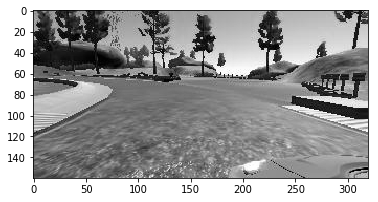

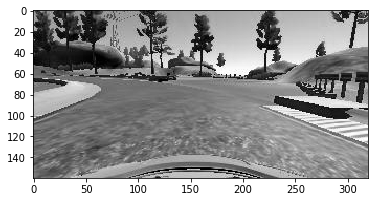

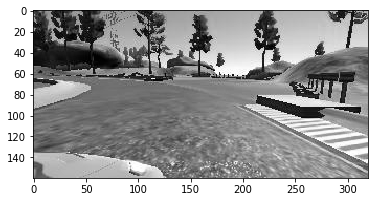

In [1]:
import os
import cv2
import pandas
import numpy as np
import matplotlib.pyplot as plt

def extract_image(f):
    im = cv2.imread(f)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2YUV)
    im = im[:,:,0]
    mn, mx = np.min(im), np.max(im)
    a, b = 0., 1.
    #im = a + ((im-mn)/(mx-mn))*(b-a)
    return im

def process_db(dir):
    with open(os.path.join(dir, 'driving_log.csv'), 'r') as f:
        data = pandas.read_csv(f, header=0, skipinitialspace=True)
        res = np.asarray(data.values)
        c, l, r, st, t, b, sp = np.split(res, 7, axis=1)
        l = np.array([extract_image(os.path.join(dir, p)) for p in l.squeeze()], dtype=np.float32)
        c = np.array([extract_image(os.path.join(dir, p)) for p in c.squeeze()], dtype=np.float32)
        r = np.array([extract_image(os.path.join(dir, p)) for p in r.squeeze()], dtype=np.float32)        
        return l, c, r, st.squeeze()
        
l, c, r, st = process_db('./data')
print(c.shape)
%matplotlib inline
plt.imshow(l[20], cmap='gray')
plt.figure()
plt.imshow(c[20], cmap='gray')
plt.figure()
plt.imshow(r[20], cmap='gray')
        

In [2]:
from sklearn.utils import shuffle

def balance_im(im, st):
    regular = im[st==0.]
    unique = im[st!=0.]
    return np.append(unique, regular[:], axis=0)

def balance_st(st):
    regular = st[st==0.]
    unique = st[st!=0.]
    return np.append(unique, regular[:], axis=0)    
    
bal_l = balance_im(l, st)
bal_c = balance_im(c, st)
bal_r = balance_im(r, st)
bal_st = balance_st(st)

features = bal_c
features = np.append(features, bal_l, axis=0)
features = np.append(features, bal_r, axis=0)

labels = bal_st
labels = np.append(labels, bal_st+0.25, axis=0)
labels = np.append(labels, bal_st-0.25, axis=0)

print(features.shape, labels.shape)

features, labels = shuffle(features, labels)
labels = labels.astype(np.float32)
features = np.reshape(features, [-1, 160, 320, 1])

X_train, y_train = features, labels
print(X_train.shape, y_train.shape)



MemoryError: 

In [ ]:
# _ = plt.hist(st, 10)
# plt.figure()
# _ = plt.hist(labels, 10)
# print(labels[labels<0.].shape)
# print(labels[labels==0.].shape)
# print(labels[labels>0.].shape)

features = features.astype(np.float32)
mn = np.min(features, axis=(1,2,3), keepdims=True)
mx = np.max(features, axis=(1,2,3), keepdims=True)
rng = (mx - mn)
features -= mn
features/=rng

print(features.shape)

In [ ]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout
from keras.layers.convolutional import Convolution2D
from keras.wrappers.scikit_learn import KerasRegressor

from keras.layers.pooling import MaxPooling2D
import numpy as np
from random import random

def my_model():
    model = Sequential()
    model.add(Convolution2D(16, 5, 5, border_mode='same', activation='relu', name='c1', input_shape=(160, 320, 1)))
    model.add(MaxPooling2D((2,2)))
    model.add(Convolution2D(32, 5, 5, border_mode='same', activation='relu', name='c2'))
    model.add(MaxPooling2D((2,2)))
    model.add(Convolution2D(64, 5, 5, border_mode='same', activation='relu', name='c3'))
    model.add(MaxPooling2D((2,2)))

    model.add(Flatten())
    model.add(Dense(64, name='d1',activation='relu'))
    model.add(Dense(32, name='d2',activation='linear'))
    model.add(Dense(16, name='d3',activation='relu'))
    model.add(Dense(1, name='d4', activation='linear'))
    
    return model


model = my_model()
model.compile('adam', 'mse', ['mse'])
history = model.fit(X_train, y_train, batch_size=32, nb_epoch=30, verbose=2, validation_split=0.2)
y_pred = model.predict(X_train)



In [ ]:
print(np.column_stack((y_train, y_pred.squeeze())))
print(model.save("model.balanced.h5"))

In [ ]:
# balancing data
# different network model
# regularization
# all colour channels

# normalization it's own layer
